In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

import numpy.typing as npt
from typing import Tuple

plt.style.use(['science', 'ieee', 'no-latex'])

In [2]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / LAMBDA
W = NA / LAMBDA
THRESHOLD = 0.5

target_path = './img_test/single_slit'
if not os.path.isdir(target_path):
	os.makedirs(target_path)

In [3]:
def generate_Ein(
	s: npt.NDArray,
	angle: int = 0,
	magnitude: int = 1
) -> npt.NDArray:
	angle = angle / 180 * np.pi
	return magnitude * np.exp(1j * K * s * np.sin(angle))

In [4]:
def freq_and_Eoutshift(
	s: npt.NDArray,
	E_out_unshift: npt.NDArray,
	Fs: int
) -> Tuple[npt.NDArray, npt.NDArray]:
	N = (s.shape[0] - 1) // 2
	freq = Fs * np.arange(-N, N + 1) / (2 * N)
	E_out_shift = np.concatenate((E_out_unshift[N + 1:], E_out_unshift[:N + 1]))
	return freq, E_out_shift

In [5]:
# sampling rate
Fs_single = 1000
# single slit space
s_single_space = 1000
s_single_width = 100
s_single = np.linspace(
	-s_single_space, s_single_space,
	2 * s_single_space * Fs_single + 1,
	dtype=np.double
)
# single slit mask
s_single_mask = np.where(np.abs(s_single) <= s_single_width, 1, 0)

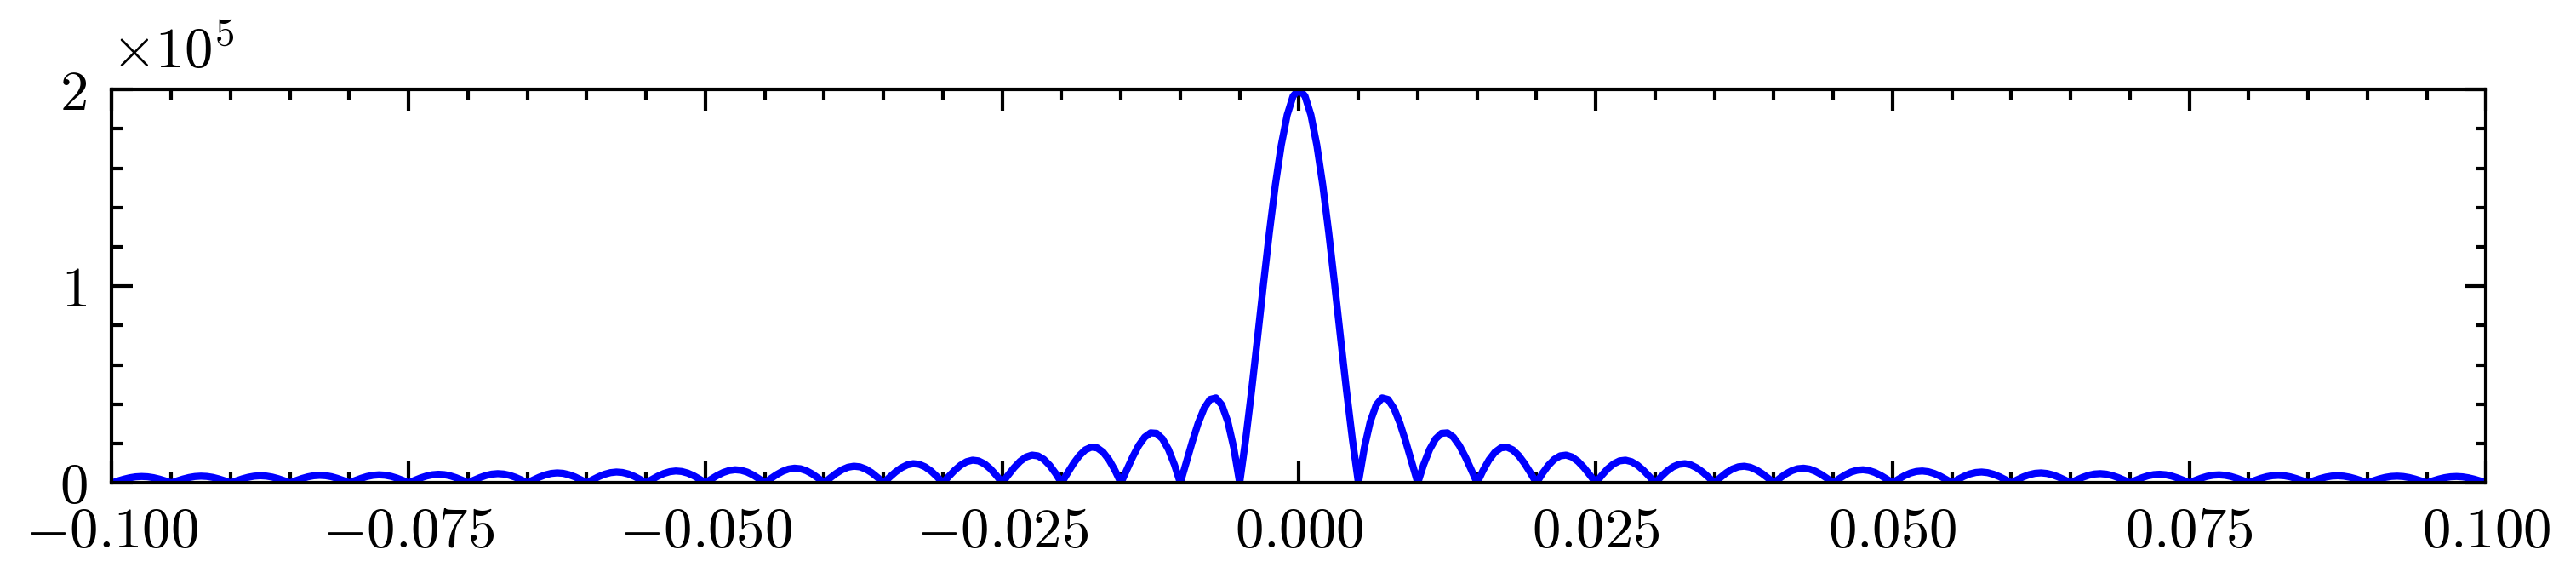

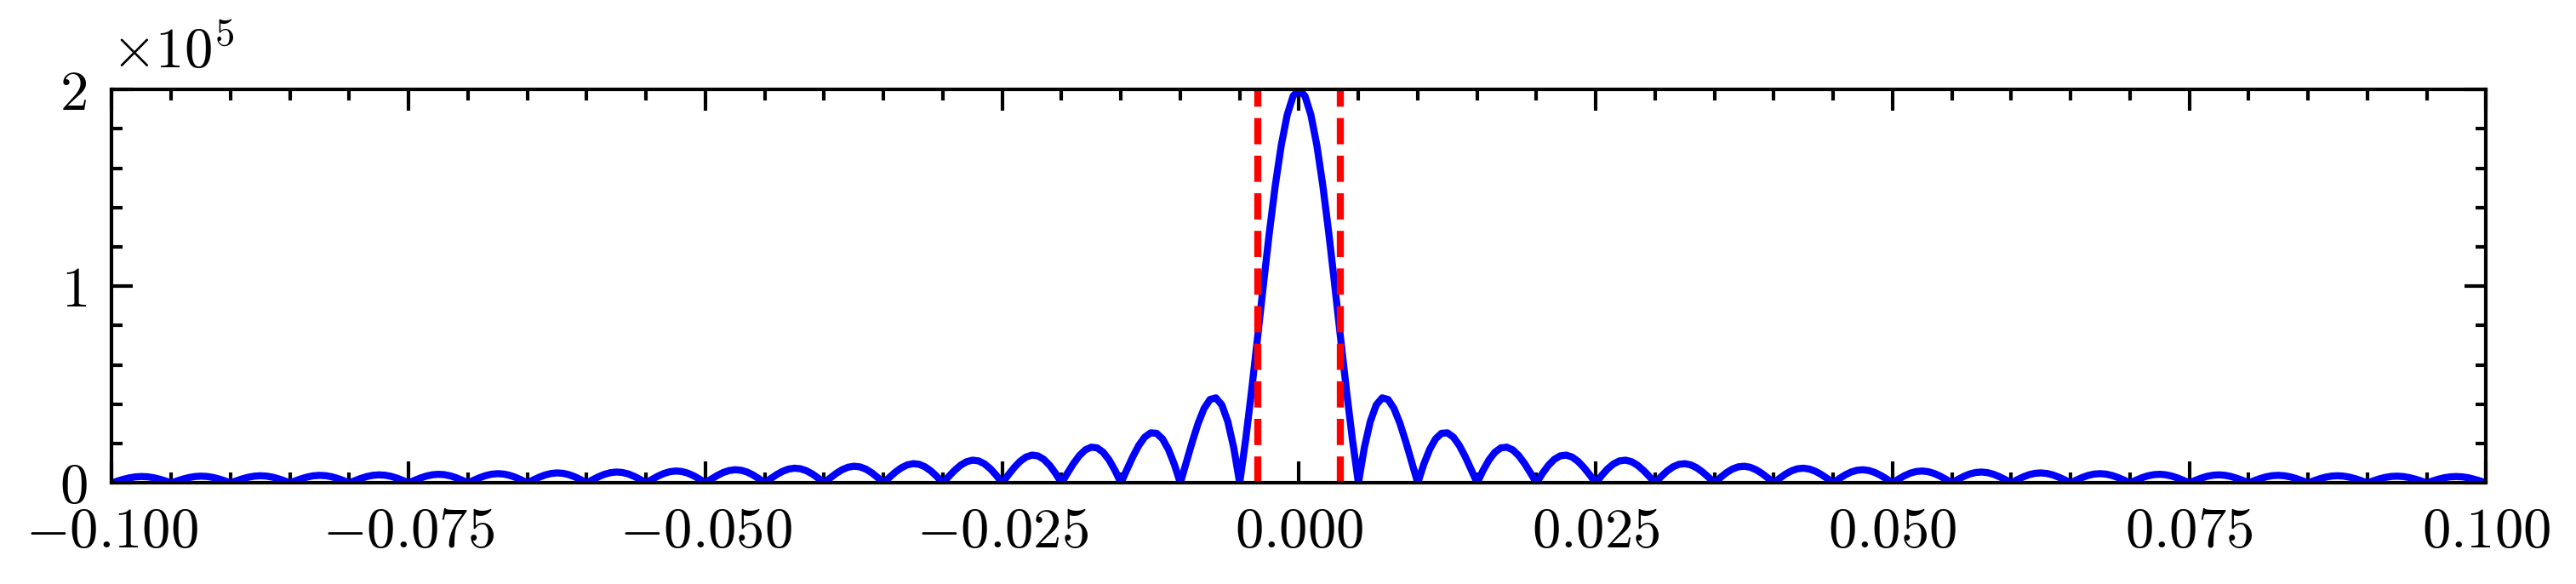

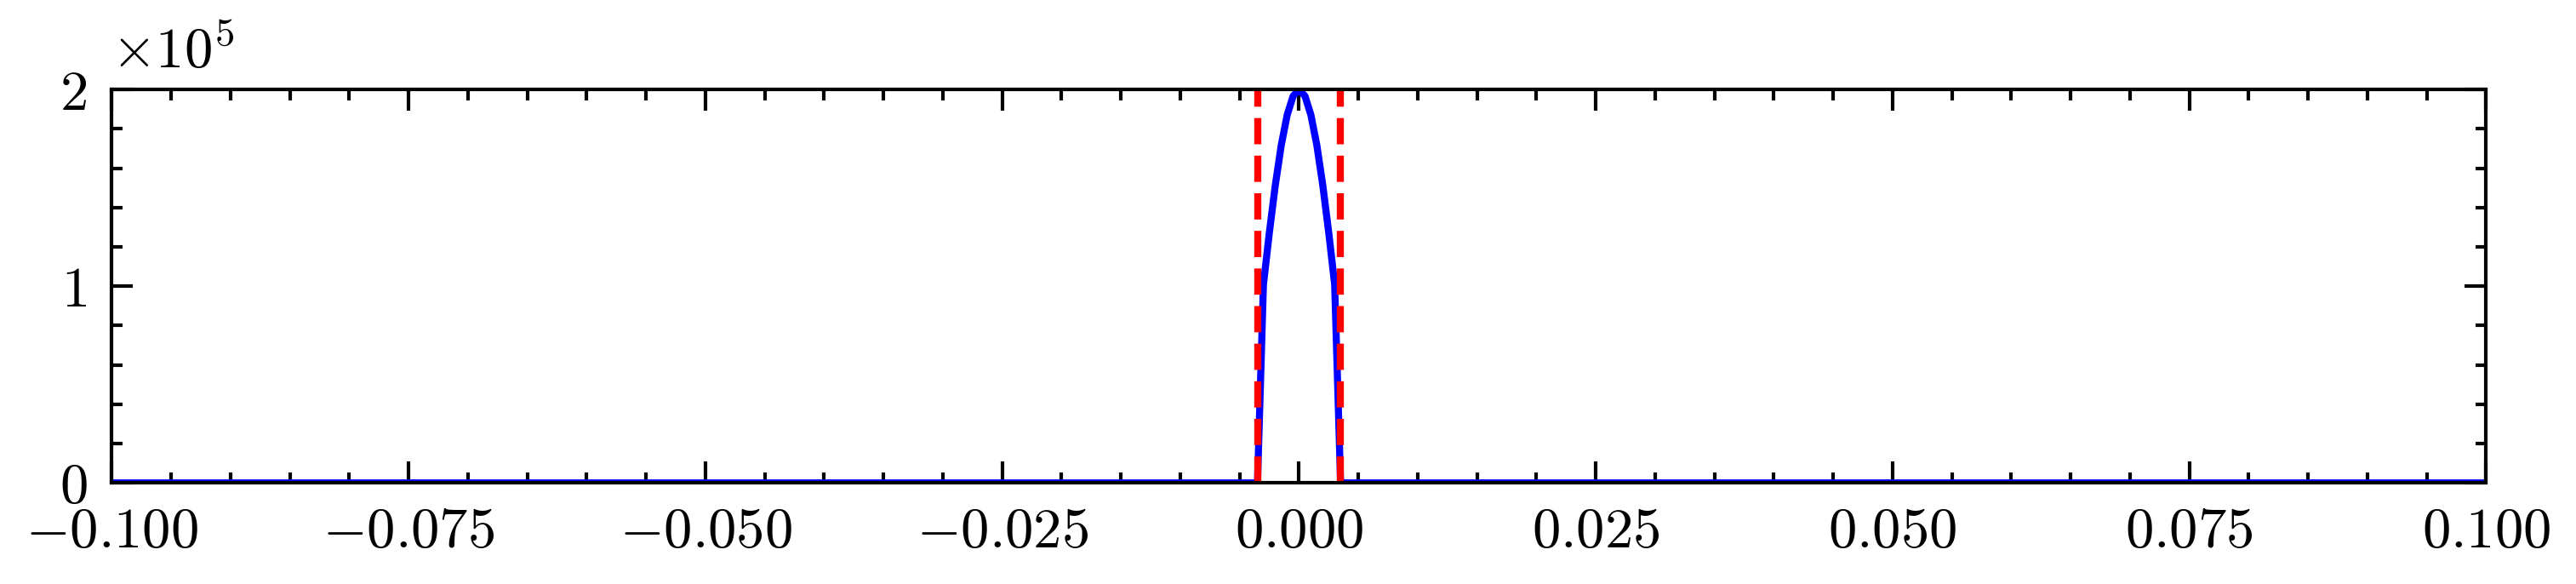

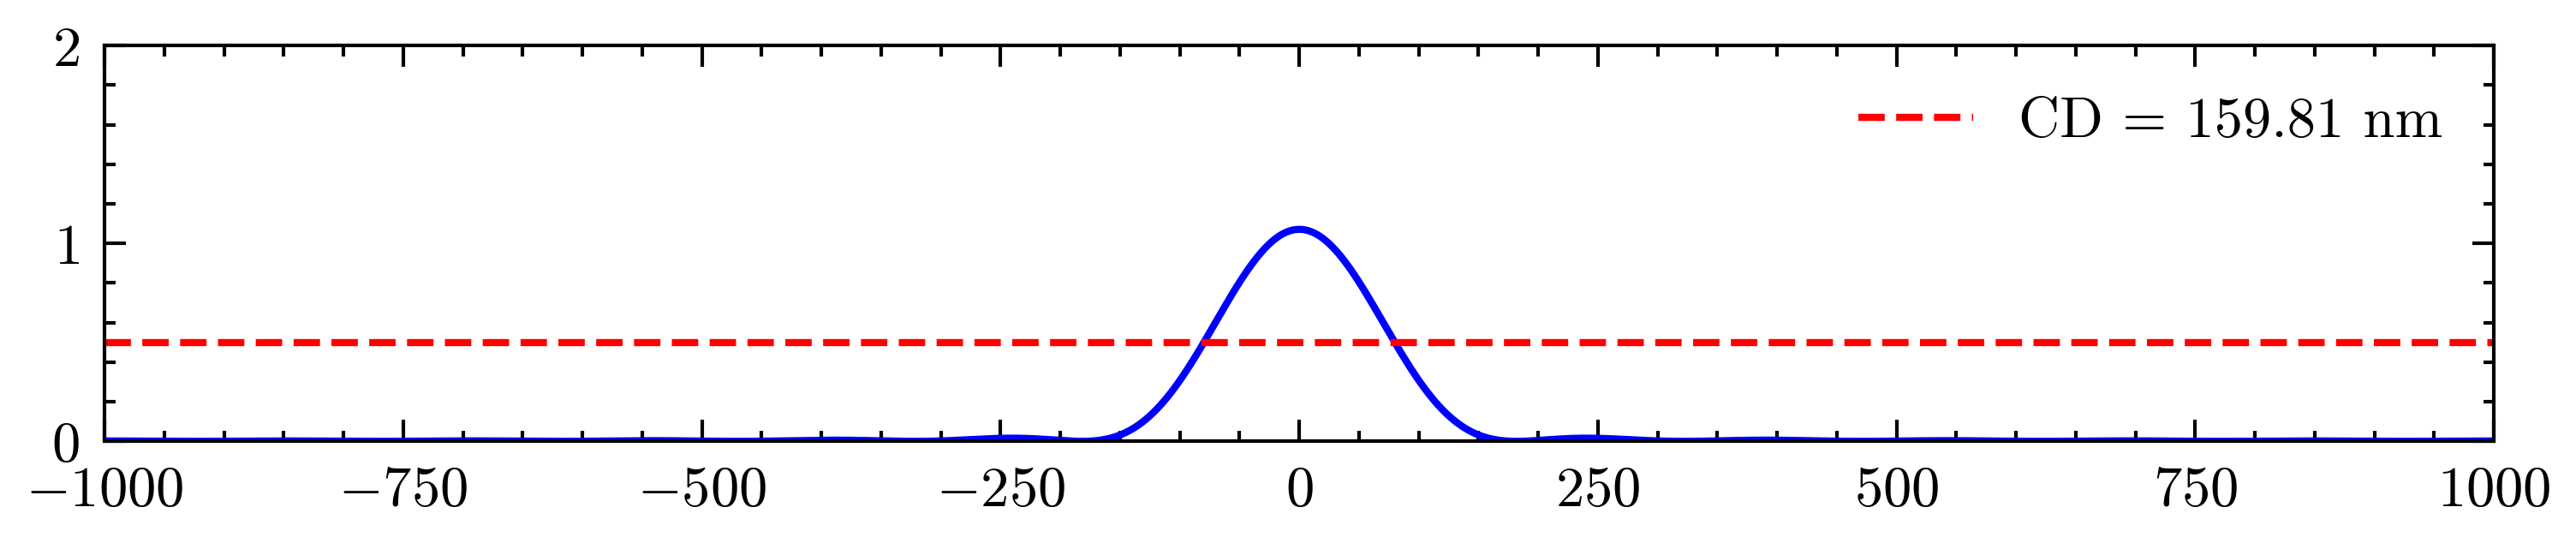

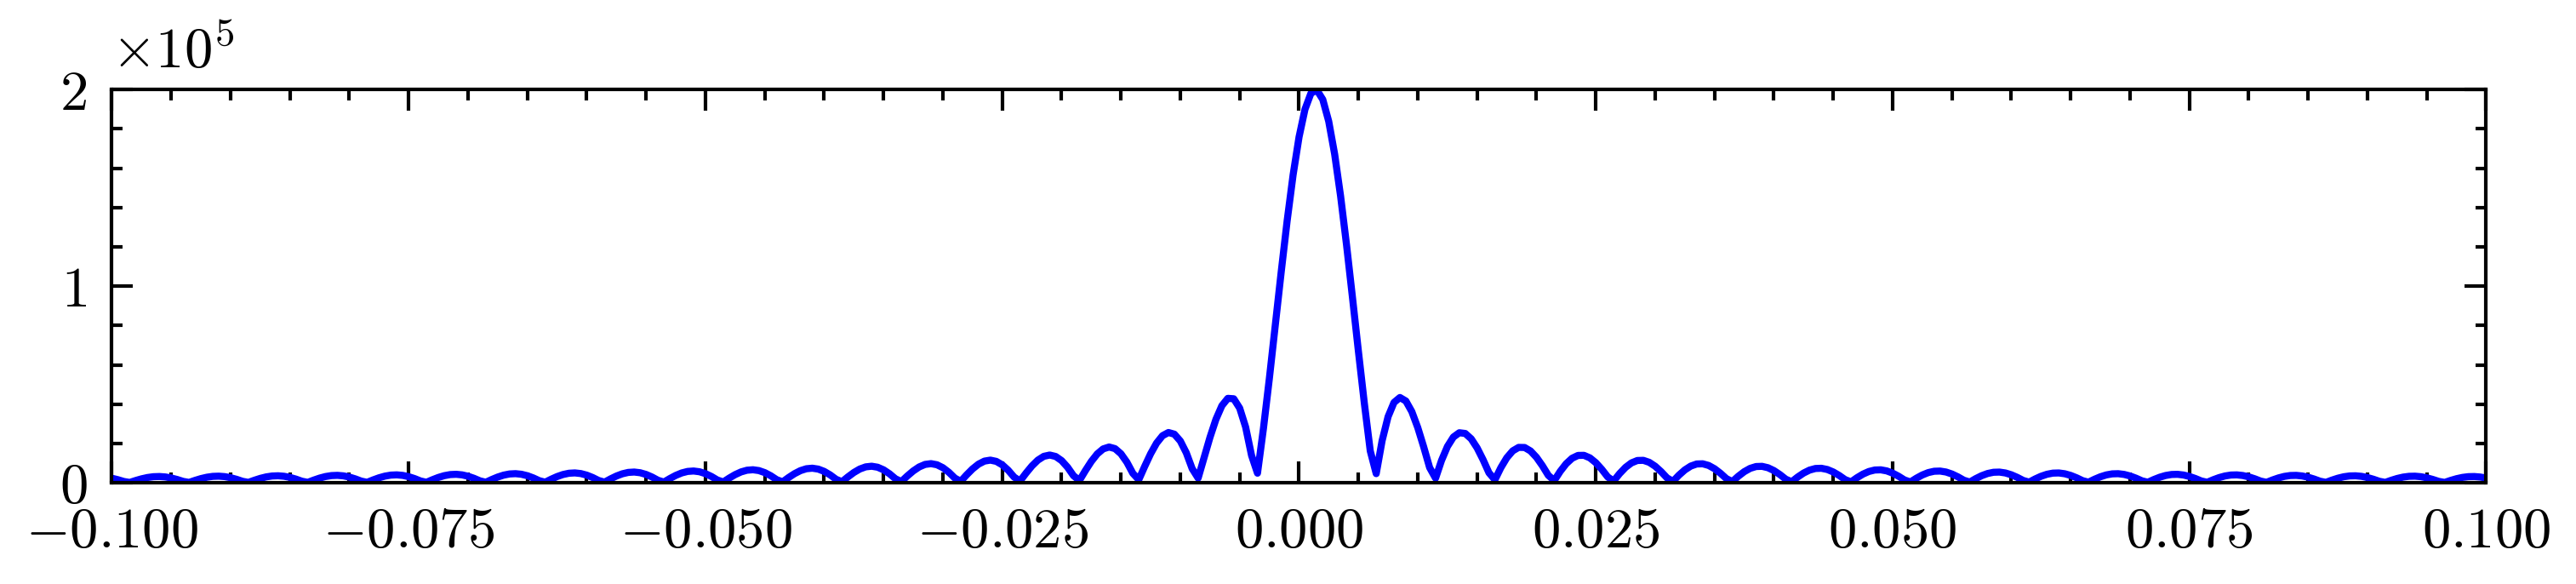

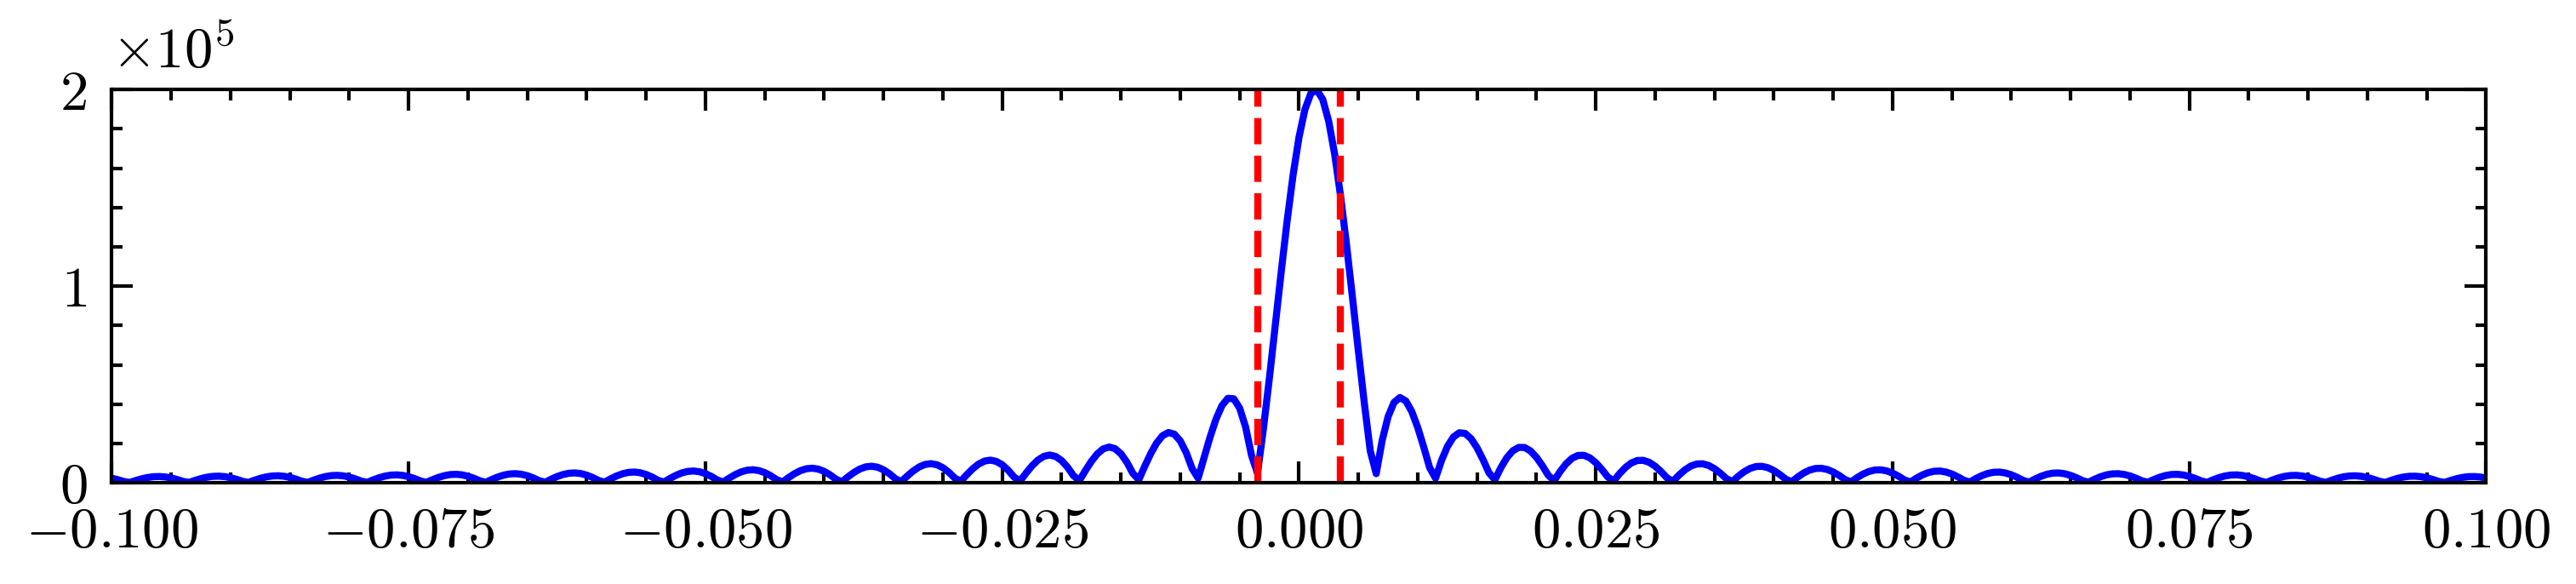

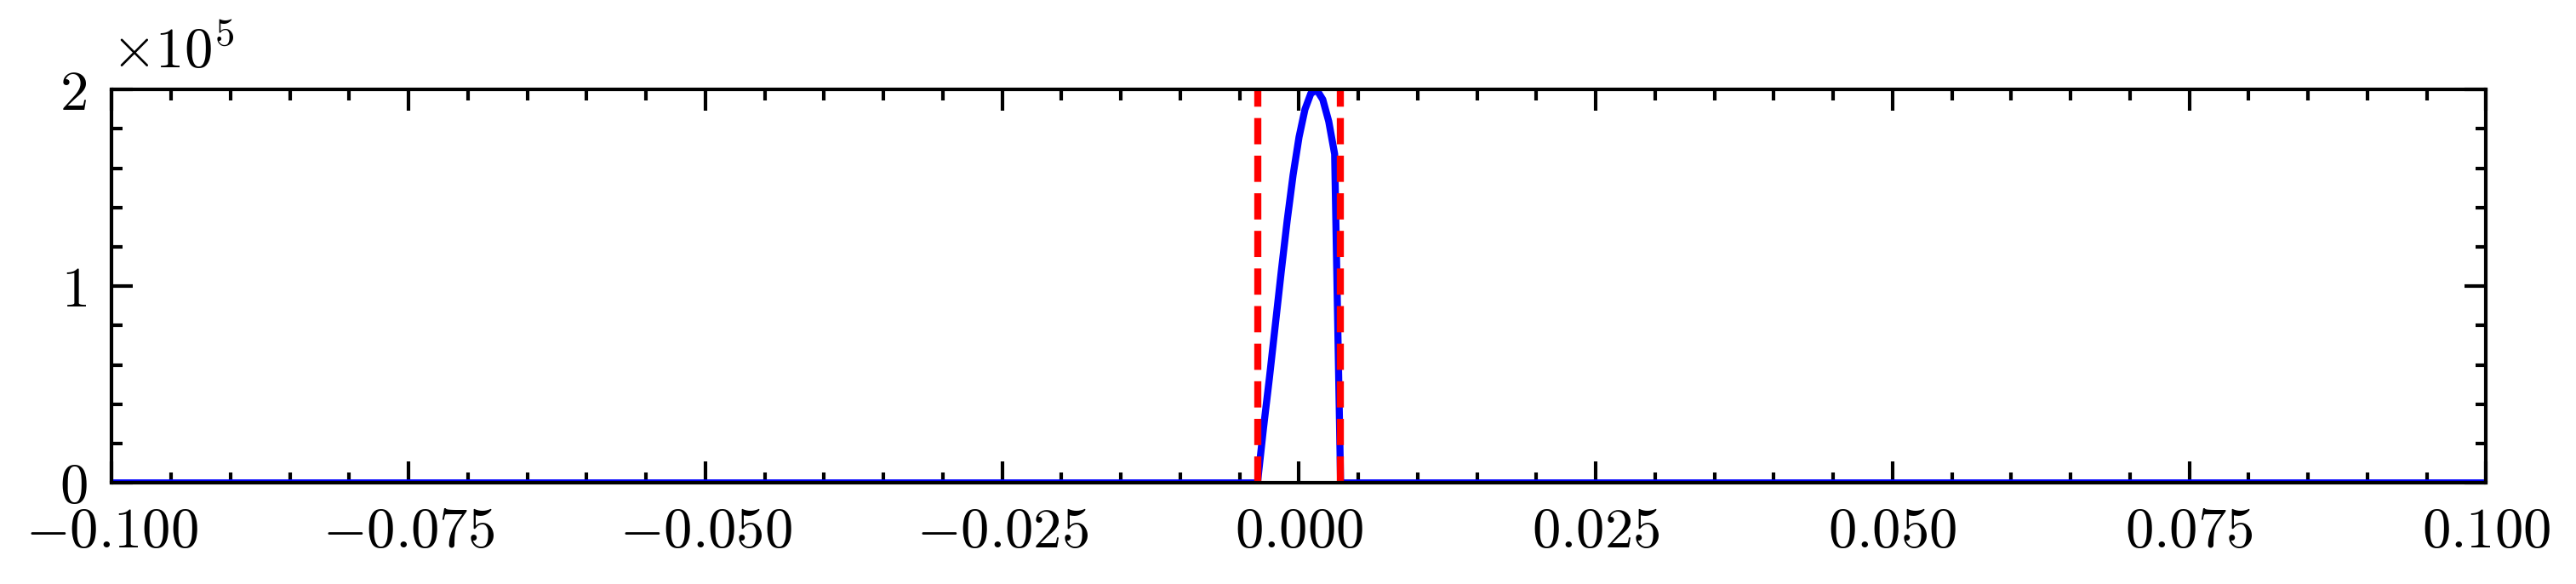

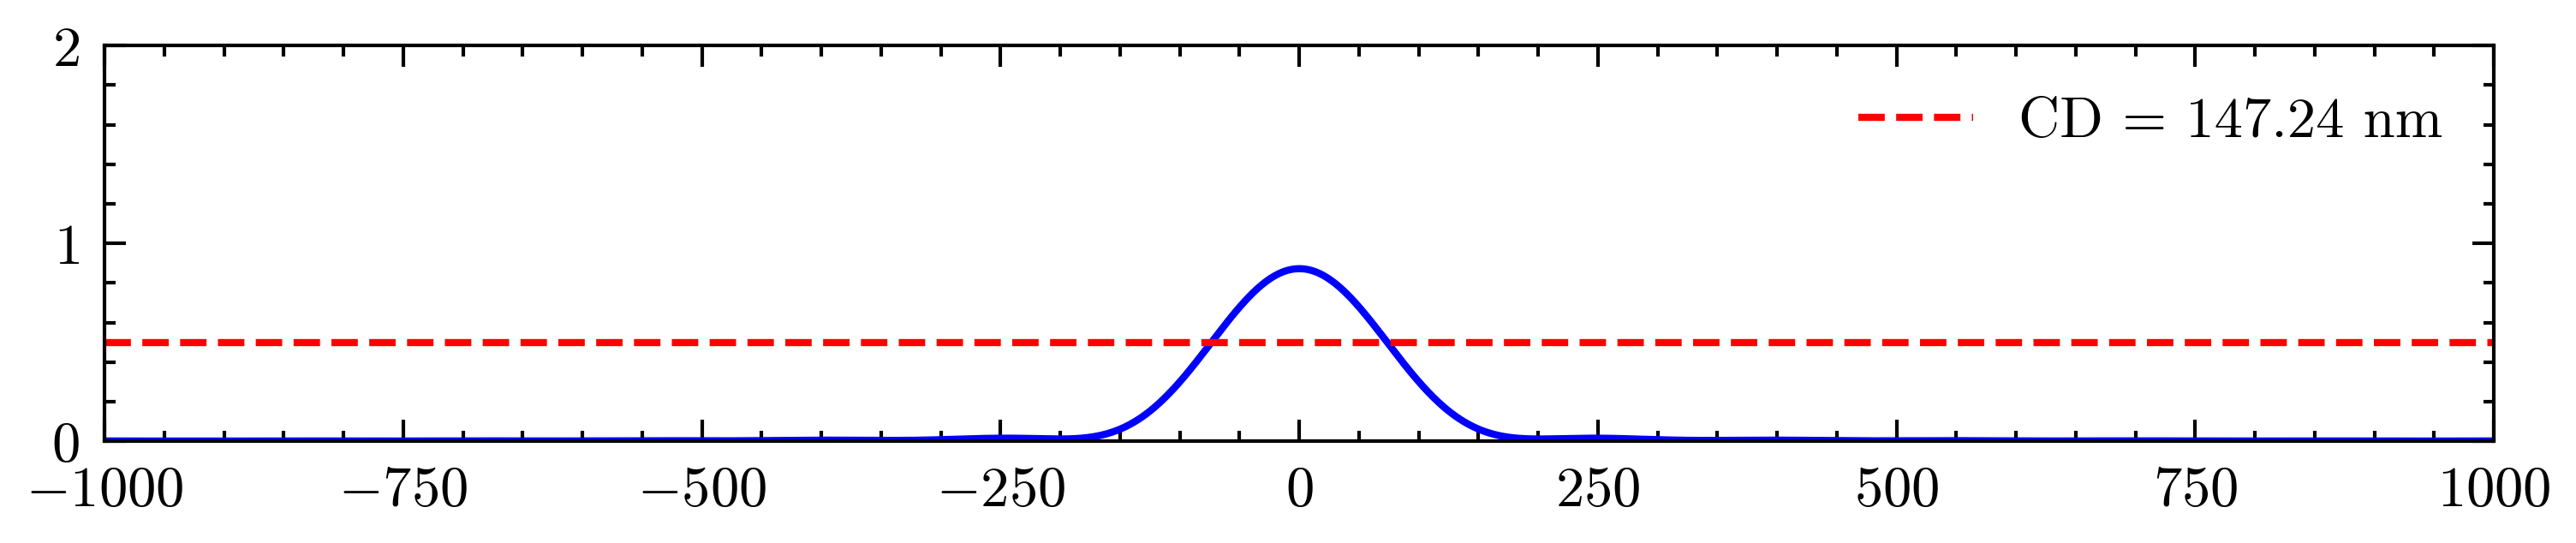

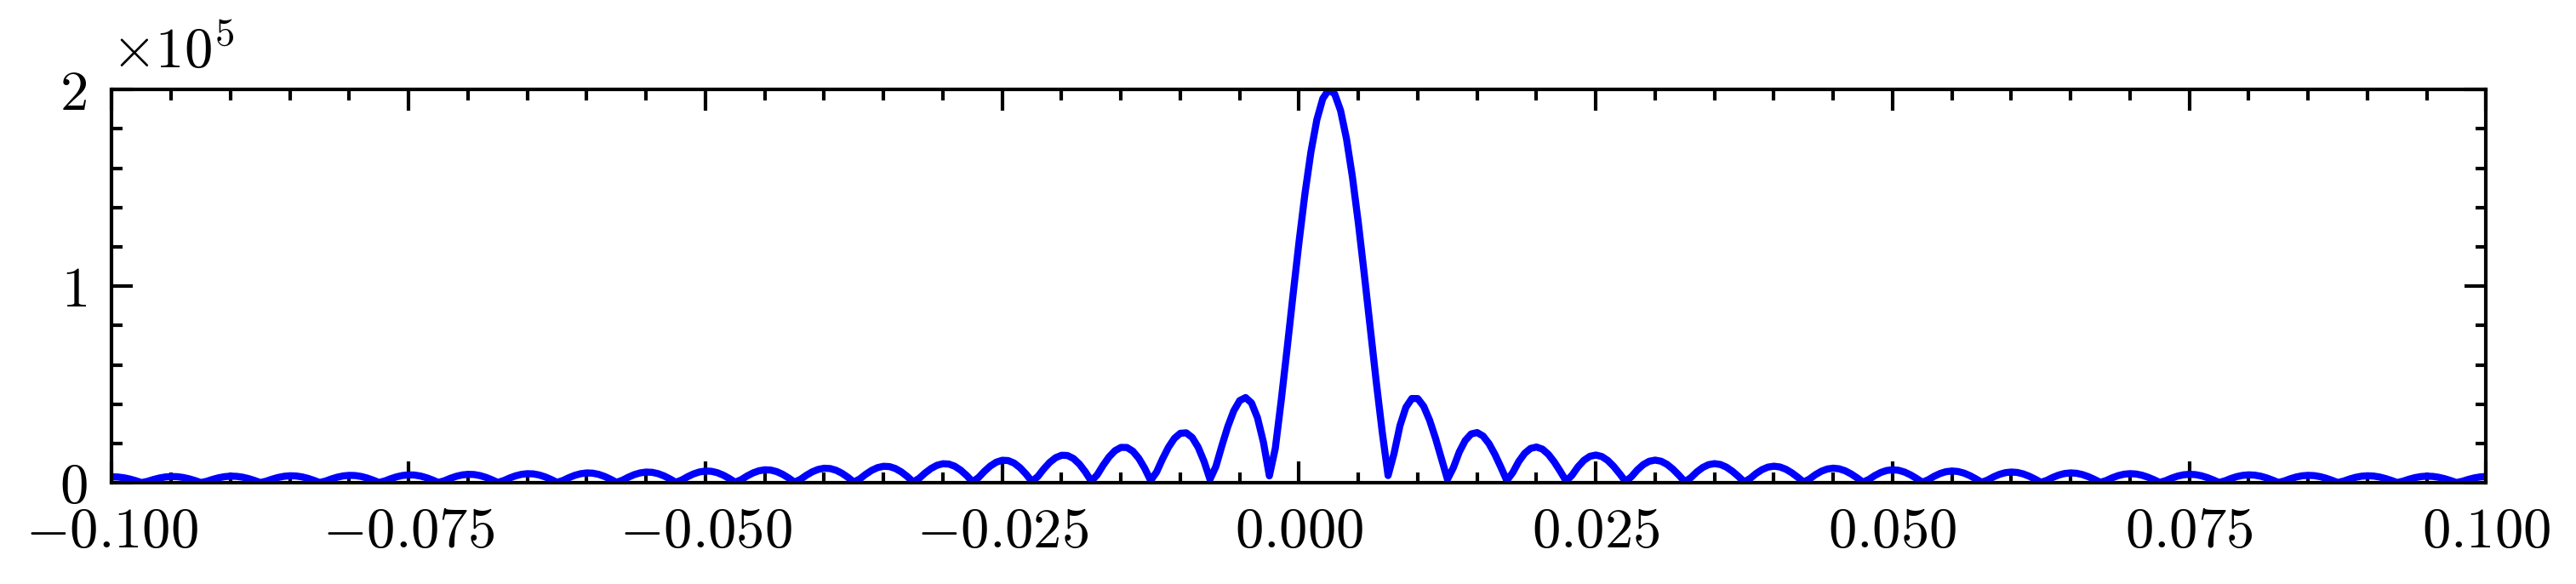

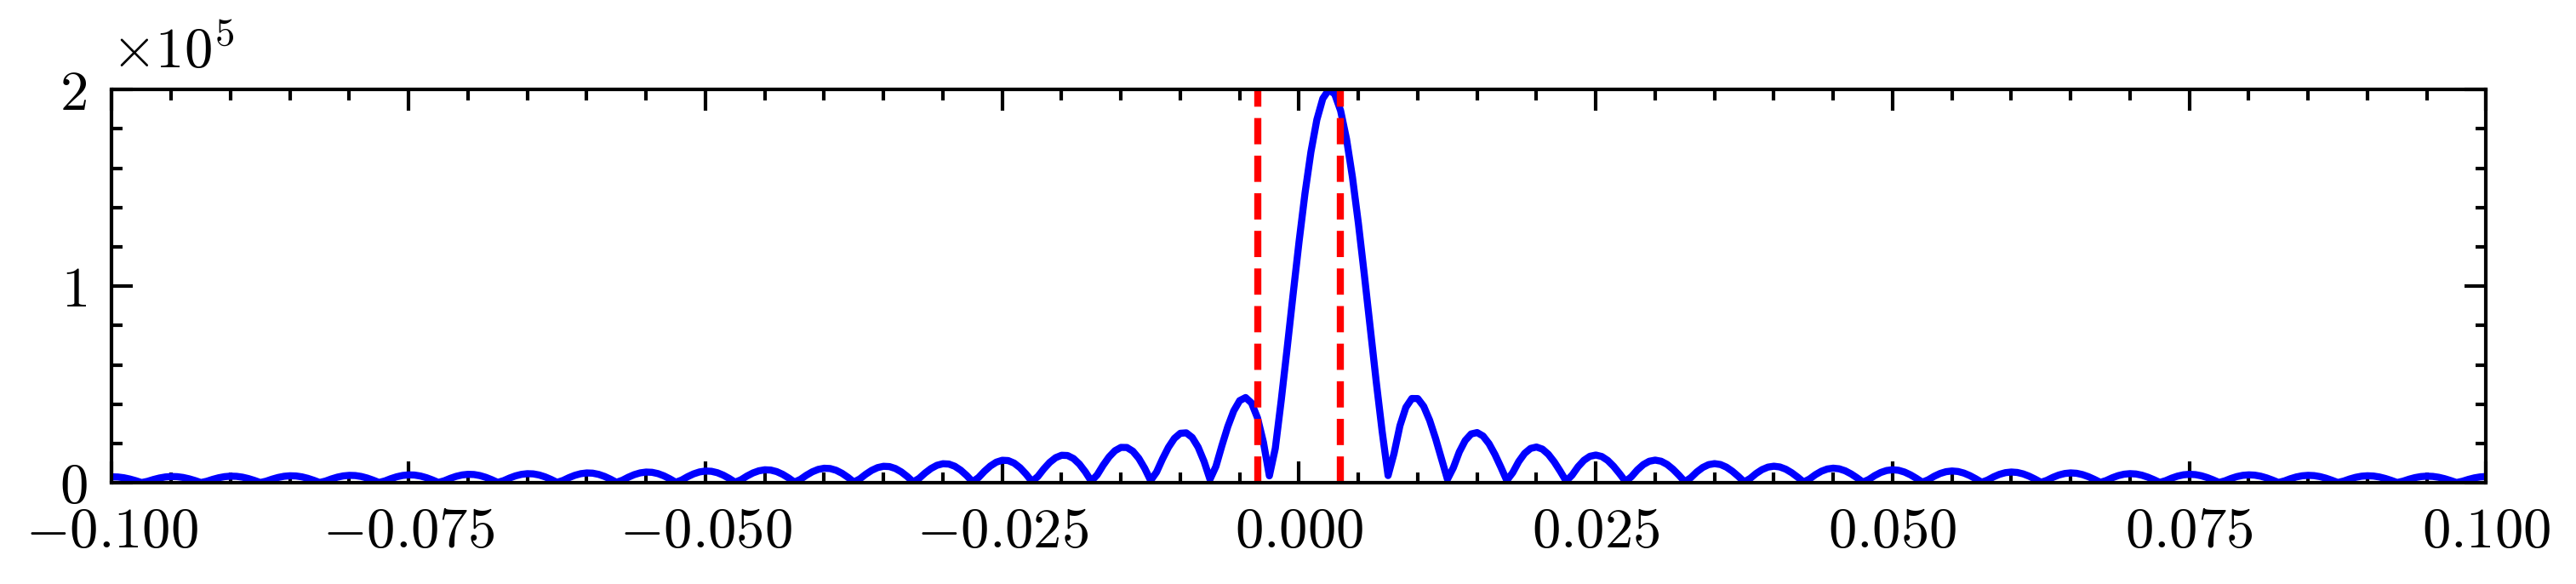

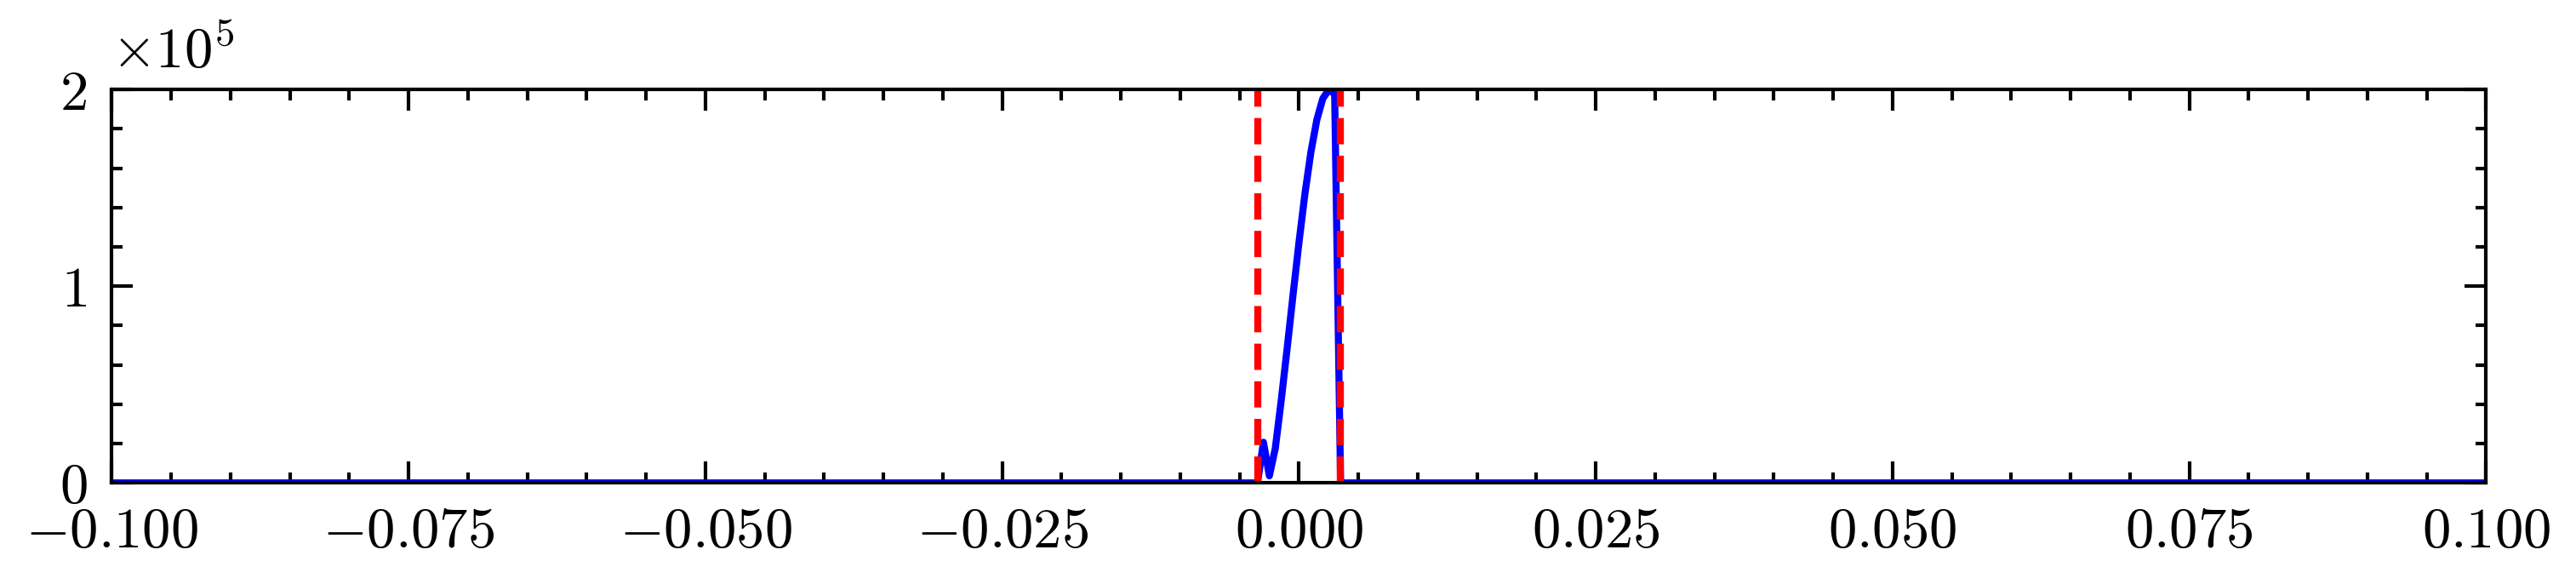

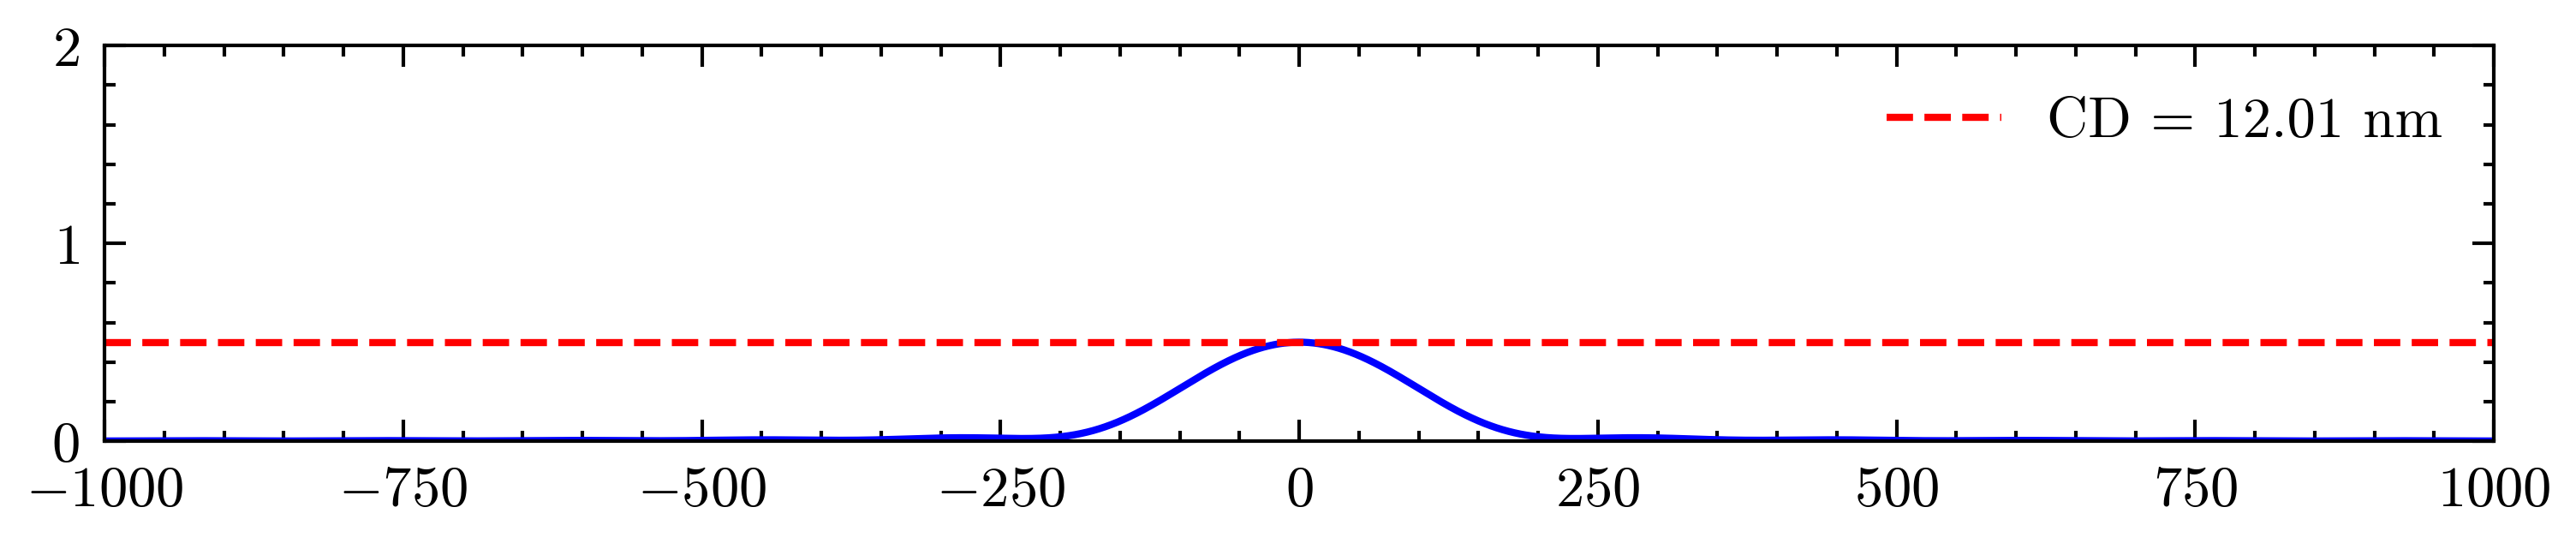

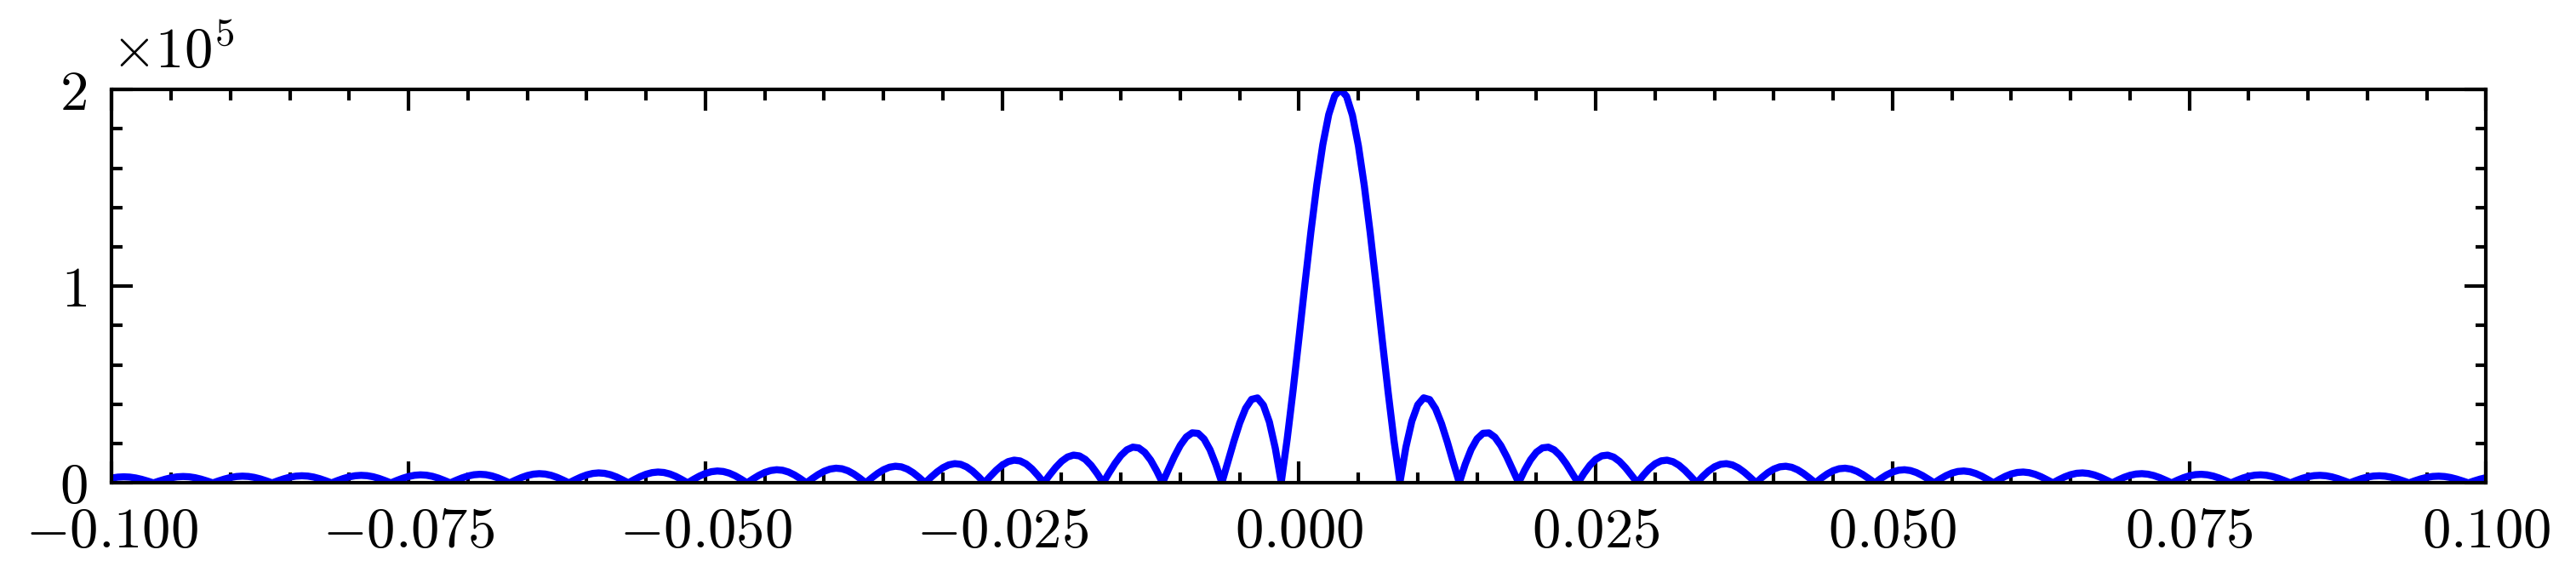

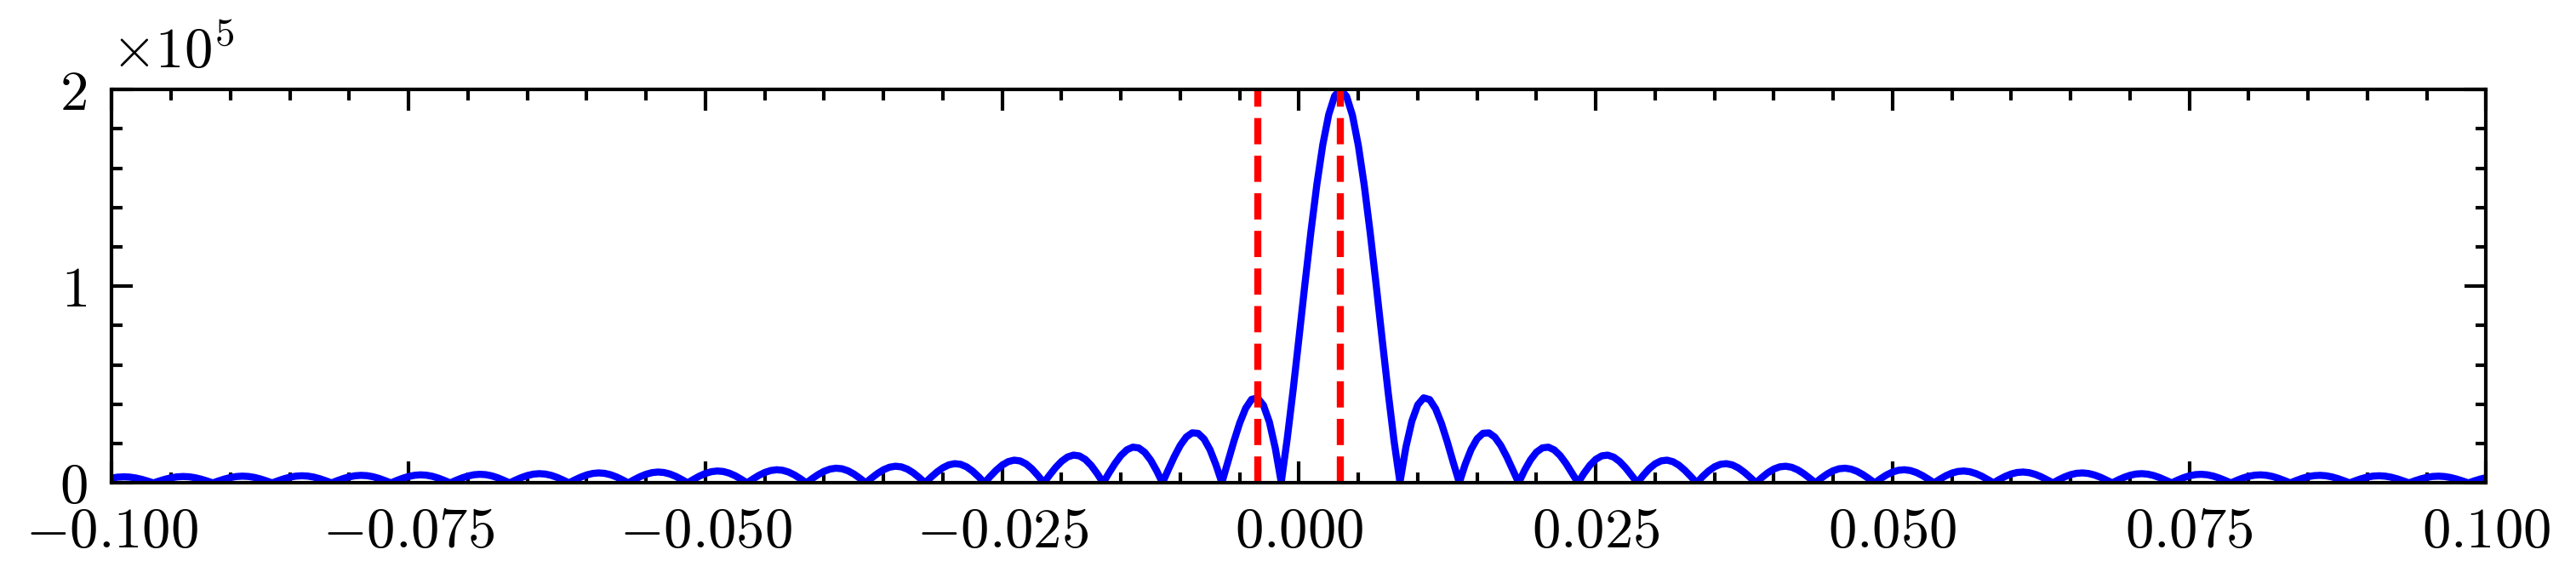

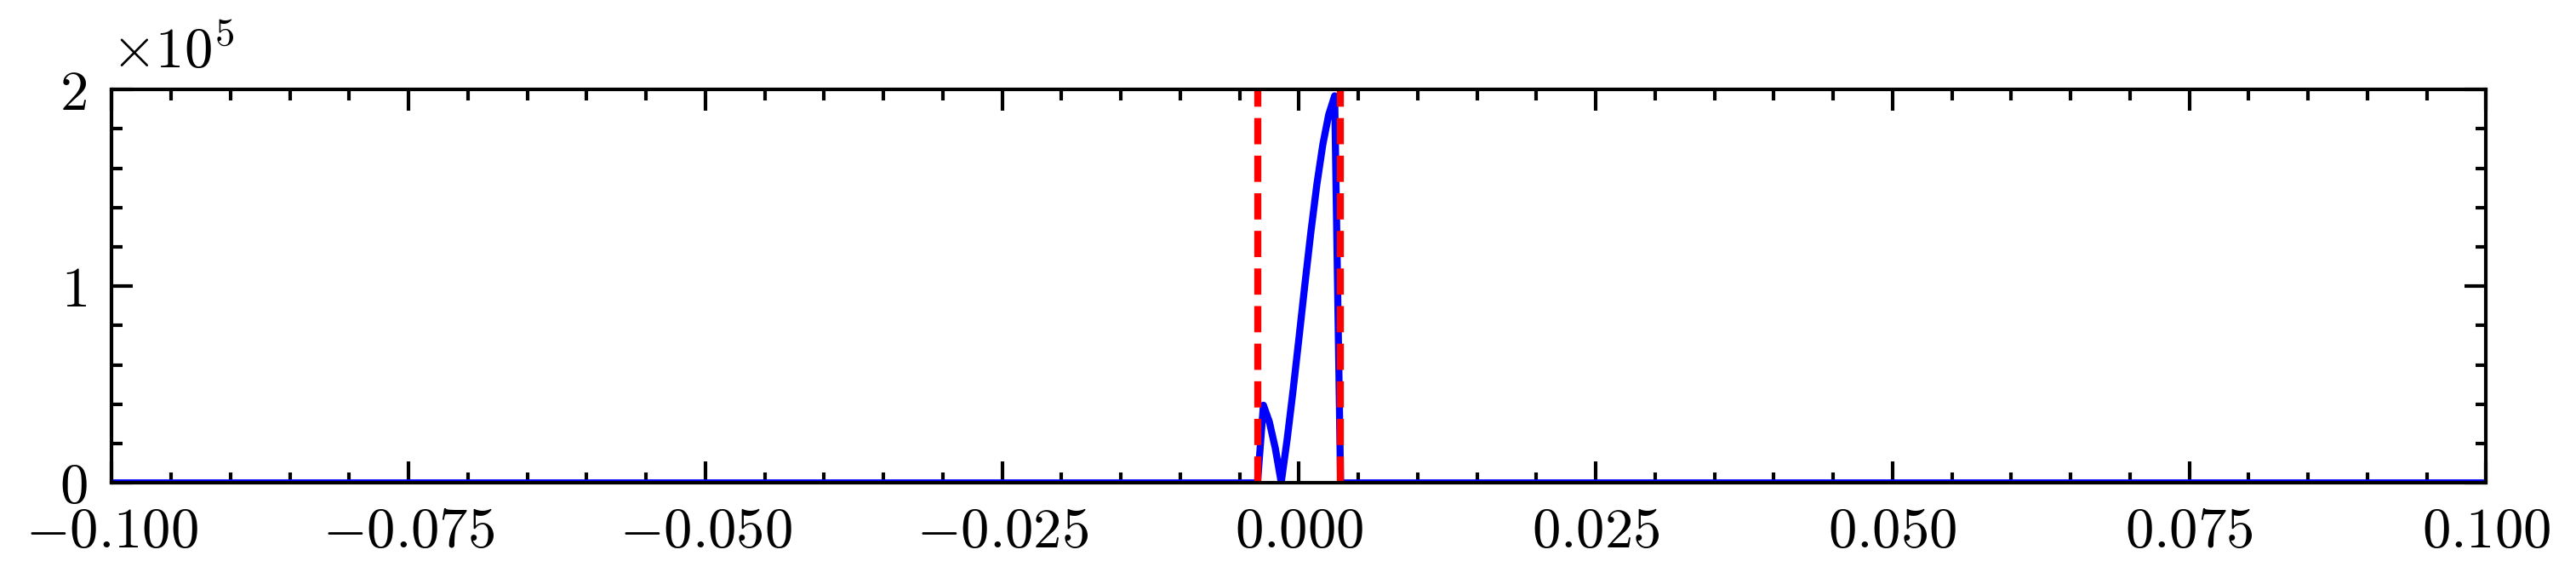

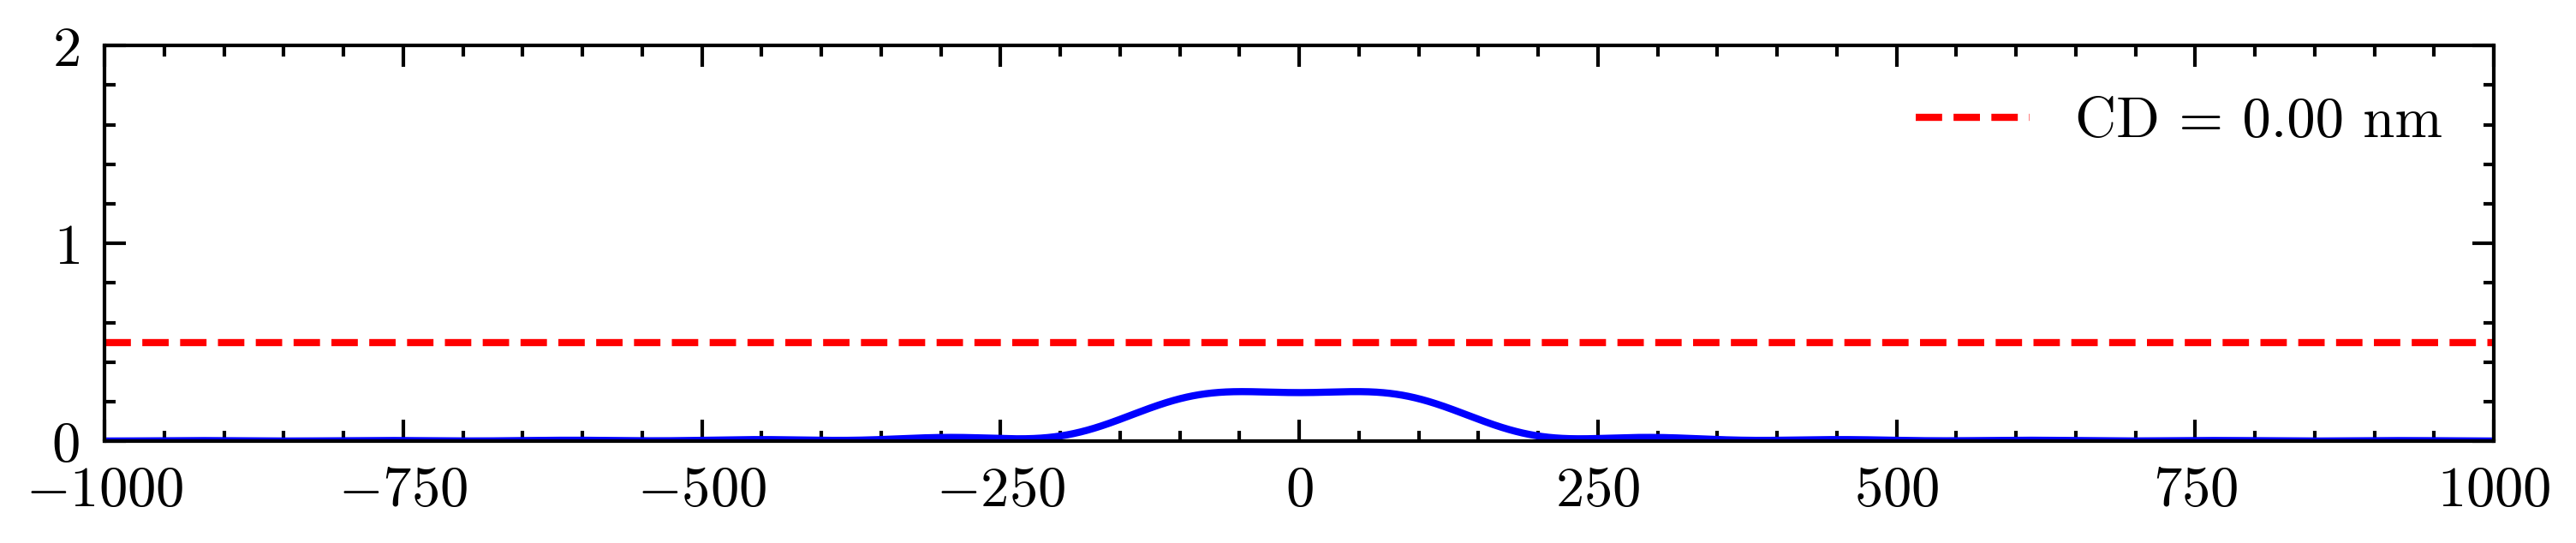

In [6]:
# single slit with different angles
thetas = [0, 20, 40, 60]
magnitude = 1
y_max = 2 * s_single_width * Fs_single * magnitude
for angle in thetas:
	# generate Ein
	E_in = generate_Ein(s_single, angle, magnitude)
	# Ein and the mask
	E_in_mask = np.multiply(E_in, s_single_mask)
	# generate Eout
	E_out_unshift = np.fft.fft(E_in_mask)
	# get freq, Eout
	freq, E_out_shift = freq_and_Eoutshift(
		s_single,
		E_out_unshift,
		Fs_single
	)

	# condition specified frequency region
	cond = np.abs(freq) <= 0.1
	# plot the frequency to E_out_shift
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(5, 5)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.savefig(f'{target_path}/single_slit_FT_{(angle // 20) + 1}.png')

	# plot the cut-off region before exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(5, 5)
	)
	plt.plot(freq[cond], np.abs(E_out_shift[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'{target_path}/single_slit_FT_cutoff_{(angle // 20) + 1}.png')

	# after exit pupil
	E_out_shift_after_exit_pupil = np.where(
		np.abs(freq) <= W, E_out_shift, 0
	)
	# plot the cut-off region after exit pupil
	plt.figure(figsize=(6, 1))
	plt.xlim(-0.1, 0.1)
	plt.ylim(0, y_max)
	plt.ticklabel_format(
		axis='y', 
		style='sci', 
		scilimits=(5, 5)
	)
	plt.plot(freq[cond], np.abs(E_out_shift_after_exit_pupil[cond]), 'b-')
	plt.axvline(
		x=-W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.axvline(
		x=W, 
		ymin=0, 
		ymax=y_max, 
		color='r', 
		linestyle='--'
	)
	plt.savefig(f'{target_path}/single_slit_cutoff_{(angle // 20) + 1}.png')

	# plot the aerial image
	E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
	I = np.multiply(np.abs(E_output), np.abs(E_output))
	try:
		freq_left = np.min(s_single[I >= THRESHOLD])
		freq_right = np.max(s_single[I >= THRESHOLD])
		CD = freq_right - freq_left
	except ValueError:
		CD = 0
	plt.figure(figsize=(6, 1))
	plt.xlim(-s_single_space, s_single_space)
	plt.ylim(0, 2)
	plt.plot(s_single, I, 'b-')
	plt.axhline(THRESHOLD, color='r', linestyle='--', label=f'CD = {CD:.2f} nm')
	plt.legend()
	plt.savefig(f'{target_path}/single_slit_aerial_{(angle // 20) + 1}.png')

In [7]:
start_width, end_width = 0, s_single_space // 2
s_single_multiple_width = np.linspace(
	start_width, 
	end_width, 
	end_width + 1, 
	dtype=int
)
s_single_measured_CD = np.zeros_like(s_single_multiple_width)
angle, magnitude = 0, 1
for width in s_single_multiple_width:
	# generate mask with different width
	mask = np.where(np.abs(s_single) <= width, 1, 0)
	# generate Ein
	E_in = generate_Ein(s_single, angle, magnitude)
	# Ein and the mask
	E_in_mask = np.multiply(E_in, mask)
	# generate Eout
	E_out_unshift = np.fft.fft(E_in_mask)
	# get freq, Eout
	freq, E_out_shift = freq_and_Eoutshift(
		s_single,
		E_out_unshift,
		Fs_single
	)
	# after exit pupil
	E_out_shift_after_exit_pupil = np.where(
		np.abs(freq) <= W, E_out_shift, 0
	)
	# plot the aerial image
	E_output = np.fft.ifft(E_out_shift_after_exit_pupil)
	I = np.multiply(np.abs(E_output), np.abs(E_output))
	# if CD can be measured
	try:
		freq_left = np.min(s_single[I >= THRESHOLD])
		freq_right = np.max(s_single[I >= THRESHOLD])
		CD = freq_right - freq_left
	# if not
	except ValueError:
		CD = 0
	s_single_measured_CD[s_single_multiple_width == width] = CD

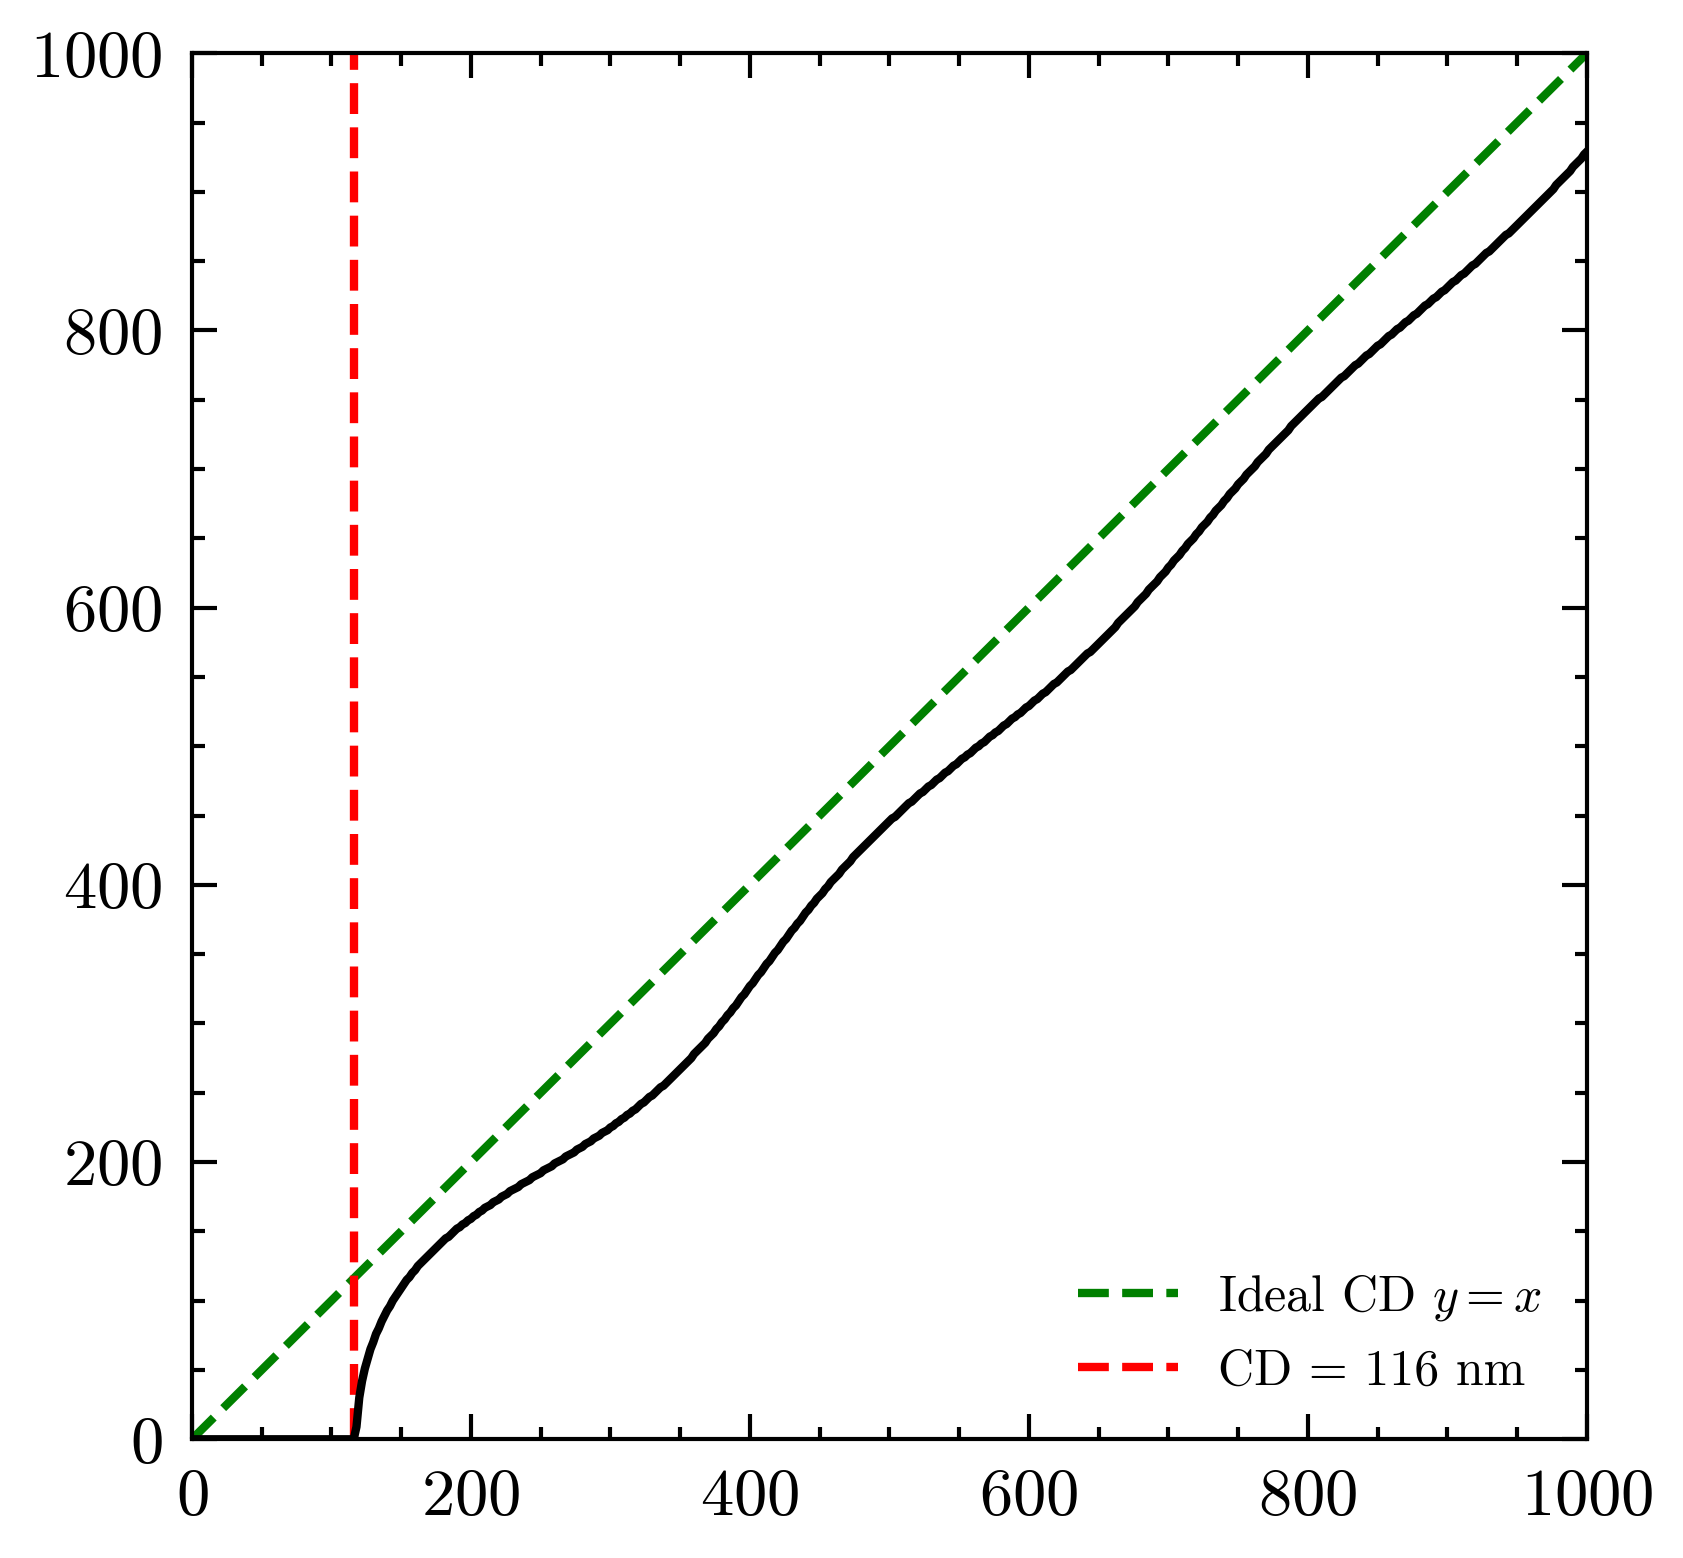

In [8]:
# plot CD and CD_measured under different CD condition
np_func = np.vectorize(lambda x: x * 2)
s_single_theoretical_CD = np_func(s_single_multiple_width)
m, M = min(s_single_theoretical_CD), max(s_single_theoretical_CD)
x_not_zero_max = np.max(s_single_theoretical_CD[s_single_measured_CD == 0])
plt.figure(figsize=(3, 3))
plt.xlim(m, M)
plt.ylim(m, M)
plt.axline(
    xy1=(0, 0), xy2=(1000, 1000), 
    color='g', linestyle='--',
    label=r'Ideal CD $y=x$'    
)
plt.axvline(
    x=x_not_zero_max, 
    ymin=m, ymax=M, 
    color='r', linestyle='--',
    label=f'CD = {x_not_zero_max} nm'
)
plt.legend(fontsize=6)
plt.plot(s_single_theoretical_CD, s_single_measured_CD)
plt.savefig(f'{target_path}/single_slit_comparison_under_different_CD.png')